In [62]:
from time import time
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [63]:
#define the states of the inverted pendulum
theta = ca.SX.sym('theta')
theta_dot = ca.SX.sym('theta_dot')
x = ca.vertcat(theta, theta_dot)

#define the control input
u=ca.SX.sym('u')

# define the pendulum system equations
ode = ca.vertcat(theta_dot, -3*ca.sin(theta) - theta_dot+u)

# ODE right hand side function
f = ca.Function('f', [x, u], [ode], ['x', 'u'], ['ode'])

T= 1
N= 100
sim_time = 10
step_horizon = T/N

# this integration options will integrate for 0.1 seconds
intg_options = {"tf": T/N, 'simplify': True, 'number_of_finite_elements': 4}

#check if f is working by giving f(x, u) and t = 0
# print(f(ca.vertcat(0.2, 0.3), 0.4))
dae = {'x': x, 'ode': ode, 'p': u}
# here p is parameters or stuffs that don't change during integration
#this intg object is a discretized version of the ode
intg = ca.integrator('intg', 'rk', dae, intg_options)

res = intg(x0=x,p=u)
x_next = res['xf']

n_states = x.numel()
n_controls = u.numel()

In [64]:
# given (x,u) compute x_next using F API
F = ca.Function('F', [x, u], [x_next], ['x', 'u'], ['x_next'])
P = ca.SX.sym('P', n_states + n_states)
X = ca.SX.sym('X', n_states, (N+1))
U = ca.SX.sym('U', n_controls, N)

In [65]:
X[:,0] = P[:n_states]
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    f_value = F(st, con)
    st_next = f_value
    X[:,k+1] = st_next

#symbolic expression for optimal trajectory given the current(initialization) state and the control input
ff = ca.Function('ff', [U, P], [X], ['U', 'P'], ['X'])

In [66]:
Q = np.diag([1, 1])
R = np.diag([0.1])

#compute the objective symbolically
obj = 0
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    obj = obj + ca.mtimes([(st-P[n_states:]).T, Q, (st-P[n_states:])]) + ca.mtimes([con.T, R, con])


In [67]:
opt_variables = U.reshape((n_controls*N,1))

In [68]:
def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))
    #print(next_state.shape)
    next_state = F(state_init, u[:, 0])
    #print(next_state.shape)
    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())

In [69]:
nlp_prob = {'f': obj, 'x': opt_variables, 'p': P}
opts = {'ipopt': {'max_iter': 2500, 'print_level': 0, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6}, 'print_time': False}

t0 = 0
state_init = ca.DM([0, 0])        # initial state
state_target = ca.DM([np.pi,0])  # target state

xx = ca.DM.zeros((n_states, int(sim_time/step_horizon)+1))
xx[:,0] = state_init
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
xx1 = np.zeros((n_states, N+1, int(sim_time/step_horizon)))
u_cl = ca.DM.zeros((n_controls, int(sim_time/step_horizon)))  # closed-loop control

print(u0.shape)
print(u_cl.shape)
mpc_iter = 0
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)
args={}

(1, 100)
(1, 1000)


In [70]:
main_loop = time()  # return time in sec
times = np.array([[0]])
while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time): # 0.1*200
    t1 = time()
    args['p'] = ca.vertcat(
        state_init,    # current state
        state_target   # target state
    )
    # optimization variable current state
    args['x0'] = ca.reshape(u0.T, n_controls*(N), 1)
    sol = solver(x0=args['x0'], p=args['p'])

    u = ca.reshape(sol['x'].T, n_controls, N)
    ff_value = ff(u.T, args['p'])
    #print(DM2Arr(ff_value).T.shape)
    xx1[:,:N+1,mpc_iter] = DM2Arr(ff_value)

    # print(u_cl.shape)
    # print(u.shape)
    u_cl = ca.horzcat(u_cl[:,1:], u[:,0])
    #append the last time step
    t = np.vstack((t,t0))

    t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

    xx[:,mpc_iter] = state_init.T

    mpc_iter = mpc_iter + 1
    t2 = time()
    print("mpc iteration", mpc_iter)
    # print(t2-t1)
    times = np.vstack((times,t2-t1))

main_loop_time = time()
ss_error = ca.norm_2(state_init - state_target)
print('\n\n')
print('Total time: ', main_loop_time - main_loop)
print('total mpc iteration: ', mpc_iter)
print('mpc running time: ', mpc_iter * step_horizon)
print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
print('final error: ', ss_error)

mpc iteration 1
mpc iteration 2
mpc iteration 3
mpc iteration 4
mpc iteration 5
mpc iteration 6
mpc iteration 7
mpc iteration 8
mpc iteration 9
mpc iteration 10
mpc iteration 11
mpc iteration 12
mpc iteration 13
mpc iteration 14
mpc iteration 15
mpc iteration 16
mpc iteration 17
mpc iteration 18
mpc iteration 19
mpc iteration 20
mpc iteration 21
mpc iteration 22
mpc iteration 23
mpc iteration 24
mpc iteration 25
mpc iteration 26
mpc iteration 27
mpc iteration 28
mpc iteration 29
mpc iteration 30
mpc iteration 31
mpc iteration 32
mpc iteration 33
mpc iteration 34
mpc iteration 35
mpc iteration 36
mpc iteration 37
mpc iteration 38
mpc iteration 39
mpc iteration 40
mpc iteration 41
mpc iteration 42
mpc iteration 43
mpc iteration 44
mpc iteration 45
mpc iteration 46
mpc iteration 47
mpc iteration 48
mpc iteration 49
mpc iteration 50
mpc iteration 51
mpc iteration 52
mpc iteration 53
mpc iteration 54
mpc iteration 55
mpc iteration 56
mpc iteration 57
mpc iteration 58
mpc iteration 59
mpc it

(1000, 1)


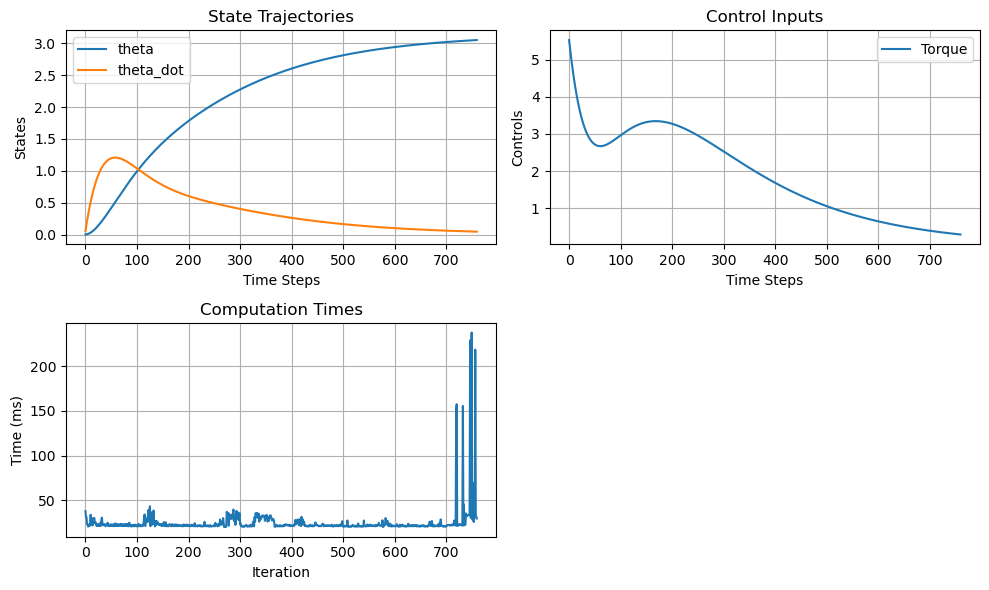

In [76]:
import matplotlib.pyplot as plt

# Plot state trajectories
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(xx.T[:mpc_iter, :])
plt.title('State Trajectories')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.grid(True)
plt.legend(['theta', 'theta_dot'])  # Added Legend

# Plot control inputs
plt.subplot(2, 2, 2)
print(u_cl.T.shape)
u_cl_np = np.array(u_cl)  # Convert to numpy array if not already
plt.plot(u_cl_np.T[-mpc_iter:, :])
plt.title('Control Inputs')
plt.xlabel('Time Steps')
plt.ylabel('Controls')
plt.grid(True)
plt.legend(['Torque'])  # Added Legend, assuming there are two controls, modify as needed

# Plot computation times
plt.subplot(2, 2, 3)
times_np = np.array(times[1:])  # Convert to numpy array and skip the first element (initialization)
plt.plot(times_np * 1000)  # Convert to milliseconds
plt.title('Computation Times')
plt.xlabel('Iteration')
plt.ylabel('Time (ms)')
plt.grid(True)
# If there is more than one line in the computation times plot, you should also add a corresponding legend here

# Display the plots
plt.tight_layout()
plt.show()
